<a href="https://colab.research.google.com/github/elooo3/Masters-NLP---B620035/blob/main/CNN_ISEAR_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing dependencies**

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup


In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Data Preprocessing

## Loading Files

In [ ]:
train_data = pd.read_excel('Dataset.xlsx', sheet_name = 'isear')
#test_data = pd.read_excel('Dataset.xlsx', sheet_name = 'isear test')

In [ ]:
train_data.head()

,Review,Emotion,Label
0,"During the period of falling in love, each tim...",joy,1
1,When I was involved in a traffic accident.,fear,2
2,When I was driving home after several days of...,anger,3
3,When I lost the person who meant the most to me.,sadness,4
4,The time I knocked a deer down - the sight of ...,disgust,5


In [ ]:
data = train_data

## **Preprocessing**

In [ ]:
# removing rows which are not useful in training the model
data.drop(["Emotion"],
          axis=1,
          inplace=True)

In [ ]:
data.tail()

,Review,Label
7506,Two years back someone invited me to be the tu...,3
7507,I had taken the responsibility to do something...,4
7508,I was at home and I heard a loud sound of spit...,5
7509,I did not do the homework that the teacher had...,6
7510,I had shouted at my younger brother and he was...,7


In [ ]:
data_labels = data.Label.values

In [ ]:
data_clean = [] # create a list which will contain all cleaned data
for i in range(0, 7511): # where 7511 is the number of sentences in the dataset 
#  store data in review and update after every cleaning process
  review = re.sub(r"[^a-zA-Z.!?']", ' ', data['Review'][i]) # re subfunction to replace any element that is not a letter with a space
  review = review.lower() # transform all capitals to lowercase letters 

  data_clean.append(review) # update corpus with each clean sentence

In [ ]:
# visualise preprocessing results
data_clean

['during the period of falling in love  each time that we met and   especially when we had not met for a long time.',
 'when i was involved in a traffic accident.',
 'when i was driving home after  several days of hard work  there   was a motorist ahead of me who was driving at    km hour and   refused  despite his low speeed to let me overtake.',
 'when i lost the person who meant the most to me. ',
 "the time i knocked a deer down   the sight of the animal's   injuries and helplessness.  the realization that the animal was   so badly hurt that it had to be put down  and when the animal   screamed at the moment of death.",
 'when i did not speak the truth.',
 'when i caused problems for somebody because he could not keep the   appointed time and this led to various consequences.',
 'when i got a letter offering me the summer job that i had applied   for.  ',
 'when i was going home alone one night in paris and a man came up   behind me and asked me if i was not afraid to be out alone 

# **Tokenization**

In [ ]:
# encode the text into a vector using the text encoder library from tensorflow
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]


In [ ]:
# for sentences of different lengths pad them with 0's so they are all of the same length
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

# **Splitting into training & test sets**

In [ ]:
#split dataset into training and test sets in ratio 75:25
np.random.seed(300)
test_idx = np.random.randint(0, 7511, 1800)
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

# **Model Building and tuning**

In [ ]:
# defining ccn architecture
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=5,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes + 1,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fivegram(x)
        x_4 = self.pool(x_4)

# merge all created layers
        merged = tf.concat([x_1, x_2, x_3,x_4], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

## **Parameters**

In [ ]:
# define parameters of neural network
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 300
NB_FILTERS = 54
FFN_UNITS = 180
NB_CLASSES = len(set(train_labels))

DROPOUT_RATE = 0.1

BATCH_SIZE = 25
NB_EPOCHS = 10

## **Training**

In [ ]:
len(set(train_labels))

7

In [ ]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [ ]:
import keras
import keras.metrics
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=['accuracy'])

In [ ]:
Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/10
237/237 [==============================] - 73s 302ms/step - loss: 1.6961 - accuracy: 0.3377
Epoch 2/10
237/237 [==============================] - 71s 301ms/step - loss: 0.9073 - accuracy: 0.6922
Epoch 3/10
237/237 [==============================] - 71s 300ms/step - loss: 0.2972 - accuracy: 0.9113
Epoch 4/10
237/237 [==============================] - 70s 296ms/step - loss: 0.0653 - accuracy: 0.9868
Epoch 5/10
237/237 [==============================] - 73s 307ms/step - loss: 0.0234 - accuracy: 0.9966
Epoch 6/10
237/237 [==============================] - 73s 308ms/step - loss: 0.0141 - accuracy: 0.9983
Epoch 7/10
237/237 [==============================] - 74s 311ms/step - loss: 0.0116 - accuracy: 0.9986
Epoch 8/10
237/237 [==============================] - 70s 297ms/step - loss: 0.0102 - accuracy: 0.9985
Epoch 9/10
237/237 [==============================] - 71s 299ms/step - loss: 0.0098 - accuracy: 0.9983
Epoch 10/10
237/237 [==============================] - 72s 303ms/step - l

In [ ]:
#print(Dcnn.summary())

## **Evaluation**

In [ ]:
# evaluating cnn on unseen data
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

72/72 [==============================] - 5s 62ms/step - loss: 1.8942 - accuracy: 0.5956
[1.8942159414291382, 0.5955555438995361]


In [ ]:
train_data['Label'].value_counts()

1    1088
3    1084
2    1083
4    1080
5    1067
7    1060
6    1049
Name: Label, dtype: int64

In [ ]:
y_pred = Dcnn.predict(test_inputs)
y_pred_class = np.argmax(y_pred, axis=1)
from sklearn.metrics import confusion_matrix
#y_pred = Dcnn.predict(test_inputs)
y_test_class = np.argmax(test_labels, axis=0)
y_test_class = y_test_class.reshape(-1,1)
y_pred_class  = y_pred_class.reshape(-1,1)
cm = confusion_matrix(test_labels, y_pred_class)

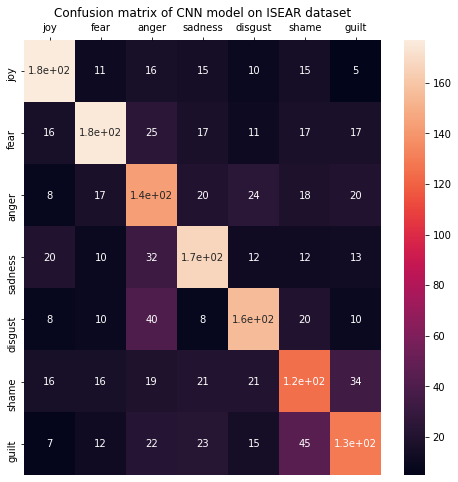

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# figure
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True)

# xticks
ax.xaxis.tick_top()
xticks_labels = ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame',
                'guilt']

yticks_labels = ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame',
                'guilt']

plt.xticks(np.arange(7) + .5, labels=yticks_labels)
plt.yticks(np.arange(7) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Confusion matrix of CNN model on ISEAR dataset'
plt.title(title)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred_class)
print(report)

              precision    recall  f1-score   support

           1       0.70      0.71      0.71       249
           2       0.70      0.63      0.66       278
           3       0.48      0.57      0.52       250
           4       0.62      0.63      0.62       266
           5       0.63      0.62      0.62       252
           6       0.50      0.50      0.50       252
           7       0.57      0.51      0.54       253

    accuracy                           0.60      1800
   macro avg       0.60      0.60      0.60      1800
weighted avg       0.60      0.60      0.60      1800



In [ ]:
    # predicting random text
    sent_to_id  = {"1":'joy',"2":'fear',"3":'anger',"4":'sadness',
                        "5":'disgust',"6":'shame',"7":'guilt'}

    

    test_inputs = [tokenizer.encode('you are a dirty boy')] # use cnn to classify text in parenthesis
    test_inputs = tf.keras.preprocessing.sequence.pad_sequences(test_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)
    sent = Dcnn.predict(test_inputs)
    sentiment = np.argmax(sent, axis=1)
    sent = np.round(np.dot(sent,100).tolist(),0)[0]
    sentiment # print out label of classified text
 

array([5])